In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

data =  pd.read_excel('중구_안심벨_후보지.xlsx')
data = data.loc[data['수요충족여부']==0,:]
gs = gpd.GeoSeries.from_wkt(data['노드 WKT'])
df = gpd.GeoDataFrame(data, geometry = gs, crs = 'epsg:4326')

In [2]:
df['경도']= df['geometry'].x
df['위도'] = df['geometry'].y

In [3]:
import sys
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False


In [4]:
s = [1,23,4]
sum(s)

28

------Configuration--------
     Number of Points 3708 
     K 320  
     Radius 0.000135 
-------- Output ------
     Running time : 100.07273149490356 seconds
     Optimal coverage points : 42737.9
선택된 최적 위치:
[[127.02042467  37.56514537]
 [127.01423709  37.56181303]
 [127.00664974  37.55459457]
 [127.01885482  37.56468563]
 [127.01709602  37.56764039]
 [127.02175668  37.55834361]
 [127.02302532  37.56123379]
 [127.00501408  37.55404312]
 [127.00399424  37.56581537]
 [127.01299758  37.55918823]
 [127.02000497  37.56529877]
 [127.01311275  37.56021805]
 [126.99611835  37.56238715]
 [127.00334444  37.56476266]
 [127.00301095  37.56495262]
 [126.98372954  37.55941593]
 [126.99216392  37.56282349]
 [126.96745704  37.56632811]
 [126.98896994  37.56267448]
 [127.02264518  37.56614562]
 [126.98913954  37.56283241]
 [126.98509305  37.55719441]
 [126.99019104  37.56808062]
 [127.01359504  37.56443805]
 [126.98665599  37.56086402]
 [126.98912806  37.56268823]
 [126.99841783  37.56478943]
 [127.

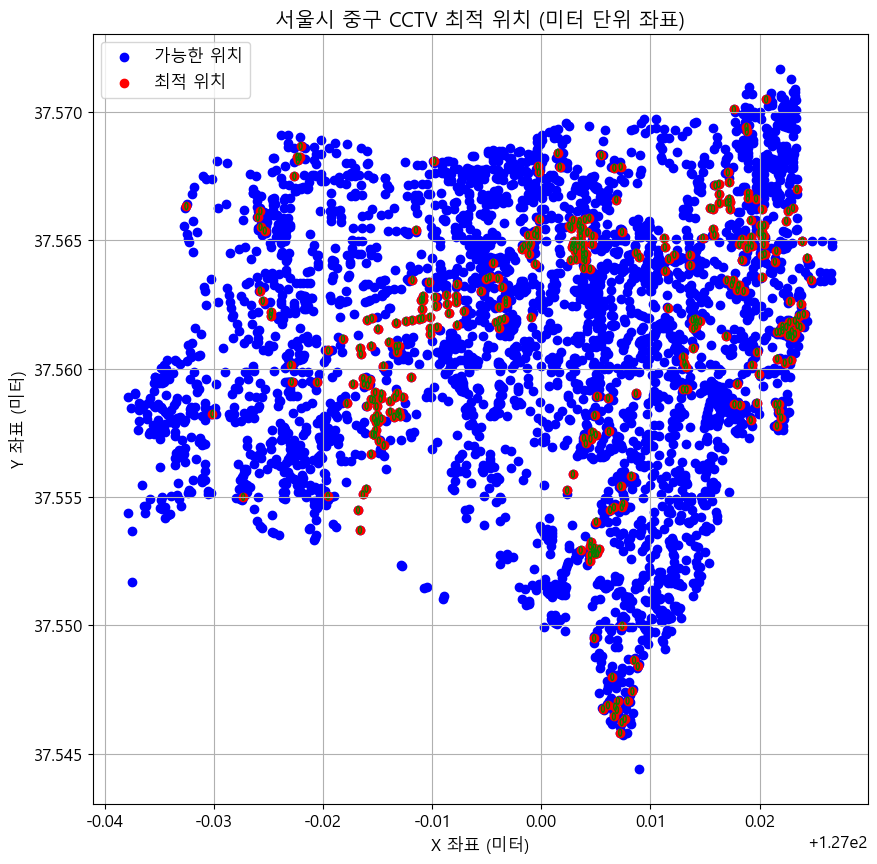

In [5]:

data = {
    'x': df['경도'],  # 미터 단위 x 좌표
    'y': df['위도'],  # 미터 단위 y 좌표
    '범죄종합점수': df['범죄종합점수']  # 범죄 종합 점수
}
df = pd.DataFrame(data)

radius = 0.000135 # 30m
K = 320  # 최적 위치

def mclp_with_crime_score(df, K, radius):

    import time
    start = time.time()
    df = df.sort_values(by='범죄종합점수', ascending=False)
    sites = df[['x', 'y']].values
    crime_scores = df['범죄종합점수'].values
    selected_sites = []
    scores = []
    print('------Configuration--------')
    print('     Number of Points %g ' % len(sites))
    print('     K %g  ' % K)
    print('     Radius %g '% radius)
    for _ in range(K):
        max_score = -np.inf
        best_site = None
        for site_index, (site, crime_score) in enumerate(zip(sites, crime_scores)):
            distance = np.sqrt(np.sum((sites - site)**2, axis=1))
            coverage_score = np.sum((distance < radius) * crime_scores)
            if coverage_score > max_score:
                max_score = coverage_score
                best_site = site
            scores.append(coverage_score)
    
        selected_sites.append(best_site)

        # 반경 내의 사이트와 범죄 점수 제거
        mask = np.sqrt(np.sum((sites - best_site)**2, axis=1)) > radius
        sites = sites[mask]
        crime_scores = crime_scores[mask]
    sum_score = sum(scores)

    end = time.time()
    print('-------- Output ------')
    print('     Running time : %s seconds' % float(end-start))
    print('     Optimal coverage points : %g' % sum_score)
    return np.array(selected_sites)

optimal_sites = mclp_with_crime_score(df, K, radius)

print("선택된 최적 위치:")
print(optimal_sites)

plt.figure(figsize=(10,10))
plt.scatter(df['x'], df['y'], c='blue', label='가능한 위치')
if len(optimal_sites) > 0:
    plt.scatter(optimal_sites[:, 0], optimal_sites[:, 1], c='red', label='최적 위치')

    # 반경 시각화
    for site in optimal_sites:
        circle = plt.Circle((site[0], site[1]), radius, color='green', fill=False)
        plt.gca().add_patch(circle)

plt.xlabel('X 좌표 (미터)')
plt.ylabel('Y 좌표 (미터)')
plt.title('서울시 중구 CCTV 최적 위치 (미터 단위 좌표)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:

import re
import pydeck as pdk

In [7]:
# 노드-링크 지도에 보여주기
df_link = pd.read_excel('중구_노드_링크_네트워크데이터.xlsx')

df_link = df_link[(df_link['노드링크 유형'] == 'LINK') &
        (df_link['시군구명'] == '중구')]  # '중구'로 변경
        # (df['수요충족여부'] == 0) #################################################################################################
df_link.reset_index(drop=True, inplace=True)

# 데이터 오류 정정 후 geometry 형식 변환하는 함수
def wkt_to_geometry(string):
    string = re.findall(r'\d+', string)
    lst = []
    lst.append([float(string[0] + '.' + string[1]), float(string[2] + '.' + string[3][:-3])])
    for i in range(3, len(string), 3):
        try:
            lst.append([float(string[i][-3:] + '.' + string[i+1]), float(string[i+2] + "." + string[i+3][:-3])])
        except:
            continue

    return lst

# 메모리 아웃 issue로 인한 데이터 컬럼 축소
df_link['geometry'] = df_link['링크 WKT'].apply(wkt_to_geometry)  # '링크 WKT' 컬럼이 있는지 확인 필요
df_link = df_link[['링크 ID','geometry']]
df_link

,링크 ID,geometry
0,162255,"[[126.98317591161188, 37.56130349138964], [126..."
1,189443,"[[127.00006984590016, 37.567561532528835], [12..."
2,200921,"[[127.023482703798, 37.561689919460186], [127...."
3,171257,"[[127.01260288002001, 37.5541111578153], [127...."
4,236970,"[[126.98943803178739, 37.56633846275766], [126..."
...,...,...
7758,184096,"[[126.97667356742252, 37.564254590919695], [12..."
7759,193517,"[[127.02100179324228, 37.56759399246612], [127..."
7760,193514,"[[126.98583937921805, 37.561717542547775], [12..."
7761,193483,"[[126.99862951099101, 37.56445146200543], [126..."


In [8]:
optimal_sites_df = pd.DataFrame(optimal_sites,columns=['경도','위도'])


In [9]:
optimal_sites_df.to_csv('MCLP_320개.csv')